In [1]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
# checking gpu support
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate

In [5]:
# import splitfolders
import os
import numpy as np
import pandas as pd
import random

In [6]:
# defining constants
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 50
     

In [7]:
# project's main directory
prj_dir = '/content/drive/MyDrive/Colab Notebooks/archive/tomato1'

In [8]:
# building tf input data pipeline
ds = tf.keras.utils.image_dataset_from_directory(
    f'{prj_dir}', 
    batch_size=BATCH_SIZE, 
    image_size=(IMG_SIZE, IMG_SIZE), 
    shuffle=True
)
   

Found 640 files belonging to 12 classes.


In [9]:
# getting class names
class_names = ds.class_names
class_names

['.ipynb_checkpoints',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy',
 'model',
 'tomato_TS',
 'tomato_mosaic_virus',
 'training']

Batch 1 Imgs shape: (32, 256, 256, 3)
Batch 1 Lbls: [ 1  2  2  7  9  6  5  3  4  2  3  1  9  1  6  6  7  1  6  5  2  6  6 10
  4  9  6  1  4  1  6 10]


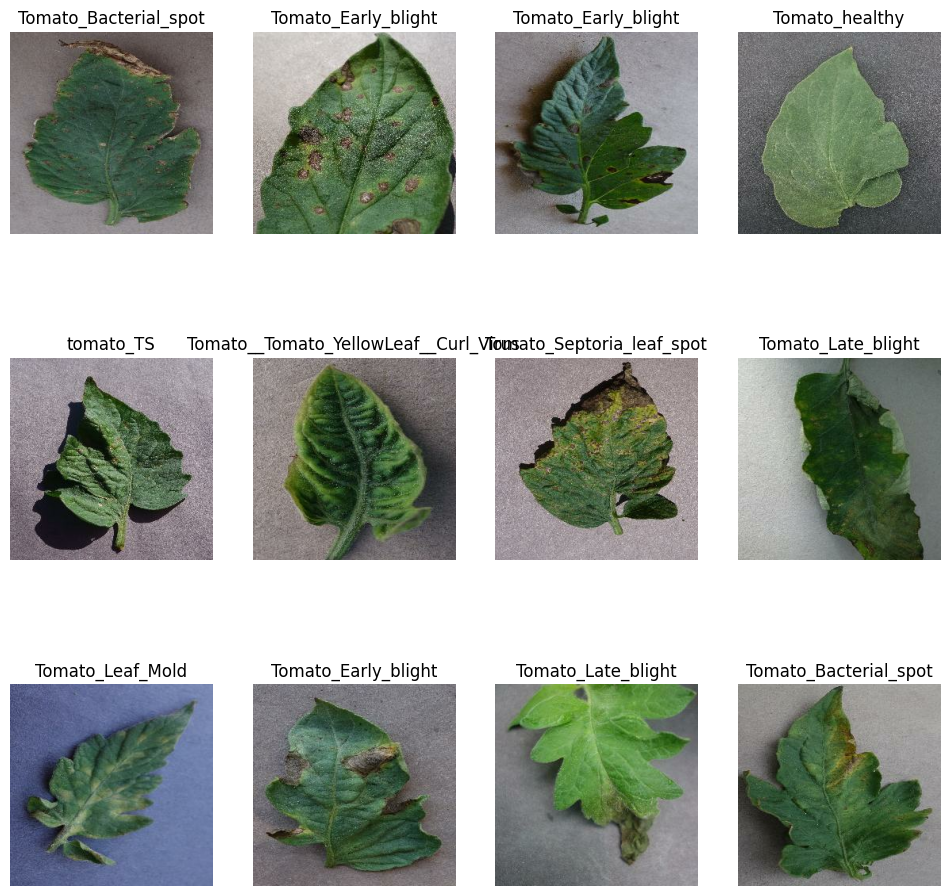

In [10]:
# displaying sample data
img = None

plt.figure(figsize=(12, 12))

for imgs, lbls in ds.take(1):
    print(f'Batch 1 Imgs shape: {imgs.shape}')
    print(f'Batch 1 Lbls: {lbls.numpy()}')

    img = imgs[0].numpy().astype('uint8') # taking sample image
    
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[lbls[i]])
        plt.axis('off')
     

In [11]:
# creating training set, validation set and testing set
ds_size = len(ds)

ds = ds.shuffle(10000, seed=12)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.72) # 72%
train_set = ds.take(train_size)

val_size = int(ds_size * 0.18) # 18%
val_set = ds.skip(train_size).take(val_size)

test_set = ds.skip(train_size).skip(val_size)
test_size = len(test_set) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 20
Train set size : 14
Val set size   : 3
Test set size  : 3


In [12]:
# optimizing tf input data pipeline performance

# caching for epochs
# prefetching tf-determined data into CPU as GPU computes - AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# resizing and rescaling layers
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE), # during prediction
    layers.experimental.preprocessing.Rescaling(1.0 / 255) # rescaling rgb values to between 0.0 and 1.0
])

In [14]:
# data augmentation to make model robust and prevent overfitting
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'), 
    layers.experimental.preprocessing.RandomRotation(0.2)
])

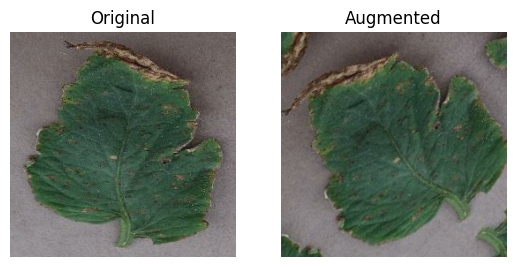

In [15]:

# testing data augmentation
imgs = [img, data_aug(img).numpy().astype('uint8')]
titles = ['Original', 'Augmented']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(imgs[i])
    plt.title(titles[i])
    plt.axis('off')

In [16]:
# applying data augmentation to training set
train_set = train_set.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
     

In [17]:
# building model with alternating Conv2D and MaxPooling2D layers
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3) # 3 channels - rgb
n_classes = len(class_names)

model = models.Sequential([
    resize_rescale, # layers.InputLayer(input_shape=input_shape) # using data generator
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(), 
    layers.Dense(units=64, activation='relu'), 
    layers.Dense(units=n_classes, activation='softmax')
])

In [18]:
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
# compiling model with optimizer, loss and metrics
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

In [21]:
train_dir = f'{prj_dir}/training' # training directory

In [22]:
train_ver = len(os.listdir(train_dir)) # latest saved training
print(f'Latest saved training ver: {train_ver}')

Latest saved training ver: 1


In [23]:
cps_dir = 'training-1/cp-{epoch:04d}.ckpt' # checkpoints directory

In [24]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cps_dir, 
    verbose=1, 
    save_weights_only=True
)

# saving weights
model.save_weights(cps_dir.format(epoch=0))

# fitting model
history = model.fit( # using data generator
    train_set, # train_data_gen
    epochs=EPOCHS, # , steps_per_epoch=train_imgs / BATCH_SIZE
    batch_size=BATCH_SIZE, 
    callbacks=[cp_callback], 
    validation_data=val_set, # validation_data=val_data_gen, validation_steps=val_imgs / BATCH_SIZE
    verbose=1
)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 2.3704 - accuracy: 0.1161
Epoch 1: saving model to training-1/cp-0001.ckpt
14/14 [==============================] - 50s 393ms/step - loss: 2.3704 - accuracy: 0.1161 - val_loss: 2.2736 - val_accuracy: 0.1042
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 2.2734 - accuracy: 0.1183
Epoch 2: saving model to training-1/cp-0002.ckpt
14/14 [==============================] - 5s 373ms/step - loss: 2.2734 - accuracy: 0.1183 - val_loss: 2.2595 - val_accuracy: 0.0938
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 2.2525 - accuracy: 0.1228
Epoch 3: saving model to training-1/cp-0003.ckpt
14/14 [==============================] - 4s 311ms/step - loss: 2.2525 - accuracy: 0.1228 - val_loss: 2.2692 - val_accuracy: 0.1146
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 2.2099 - accuracy: 0.1228
Epoch 4: saving model to training-1/cp-0004.ckpt
14/14 [===========================

In [25]:
# copying checkpoints to Drive
!cp -r training-1 '{prj_dir}/training'

In [26]:
# getting metrics at every epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

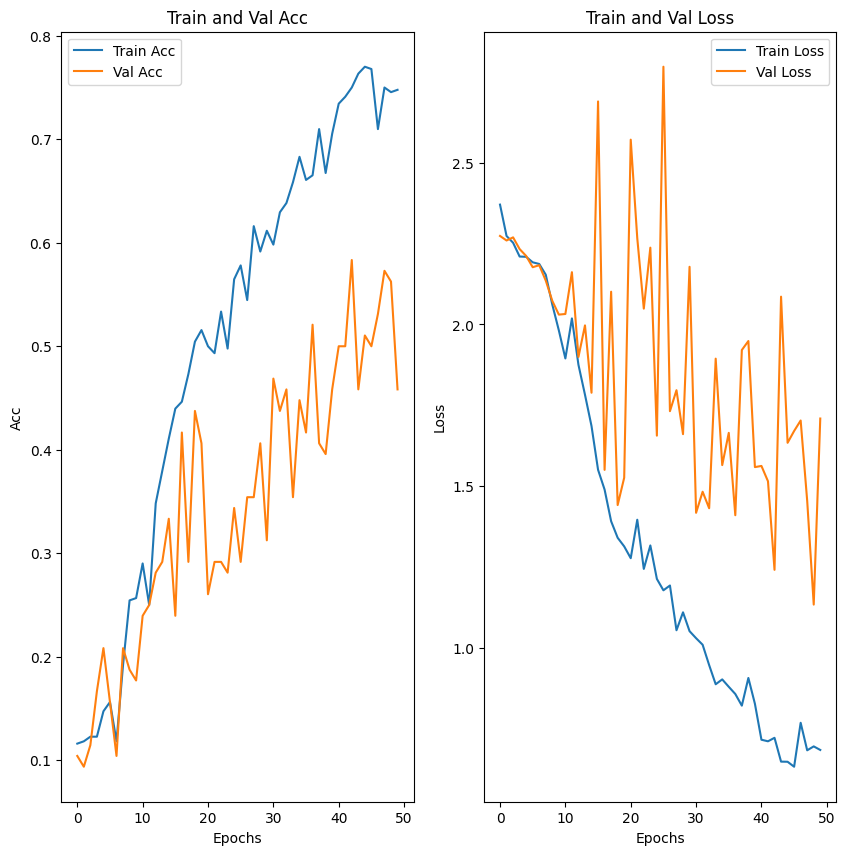

In [27]:
# plotting metrics at every epoch
train_metrics = [train_acc, train_loss]
val_metrics = [val_acc, val_loss]
metrics = ['Acc', 'Loss']

plt.figure(figsize=(10, 10))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(EPOCHS), train_metrics[i], label=f'Train {metrics[i]}')
    plt.plot(range(EPOCHS), val_metrics[i], label=f'Val {metrics[i]}')
    plt.xlabel('Epochs')
    plt.ylabel(metrics[i])
    plt.title(f'Train and Val {metrics[i]}')
    plt.legend()

In [31]:
models_dir = f'{prj_dir}/model' # models directory
# loading model if saved model is available
model = models.load_model(f'{models_dir}/1')

In [32]:
# evaluating model using testing set
metrics = model.evaluate(test_set)
print(f'Loss : {round(100 * metrics[0], 2)}%')
print(f'Acc  : {round(100 * metrics[1], 2)}%')

3/3 [==============================] - 2s 33ms/step - loss: 4.2158 - accuracy: 0.4792
Loss : 421.58%
Acc  : 47.92%


In [33]:

# predicting labels of testing set and getting their confidences
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(test_size):
    for imgs, lbls in test_set.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break

1/1 [==============================] - 0s 40ms/step


In [34]:
# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [35]:
# getting confusion matrix
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  2  0  2  2  0  0  0]
 [ 0  0  1  0  0  0  1  2  2  0  0  0]
 [ 0  2  0 11  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  6  0  0]
 [ 0  0  0  0  2  5  0  4  0  2  0  0]
 [ 0  0  0  0  0  0 12  0  2  1  0  0]
 [ 0  0  0  0  2  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]


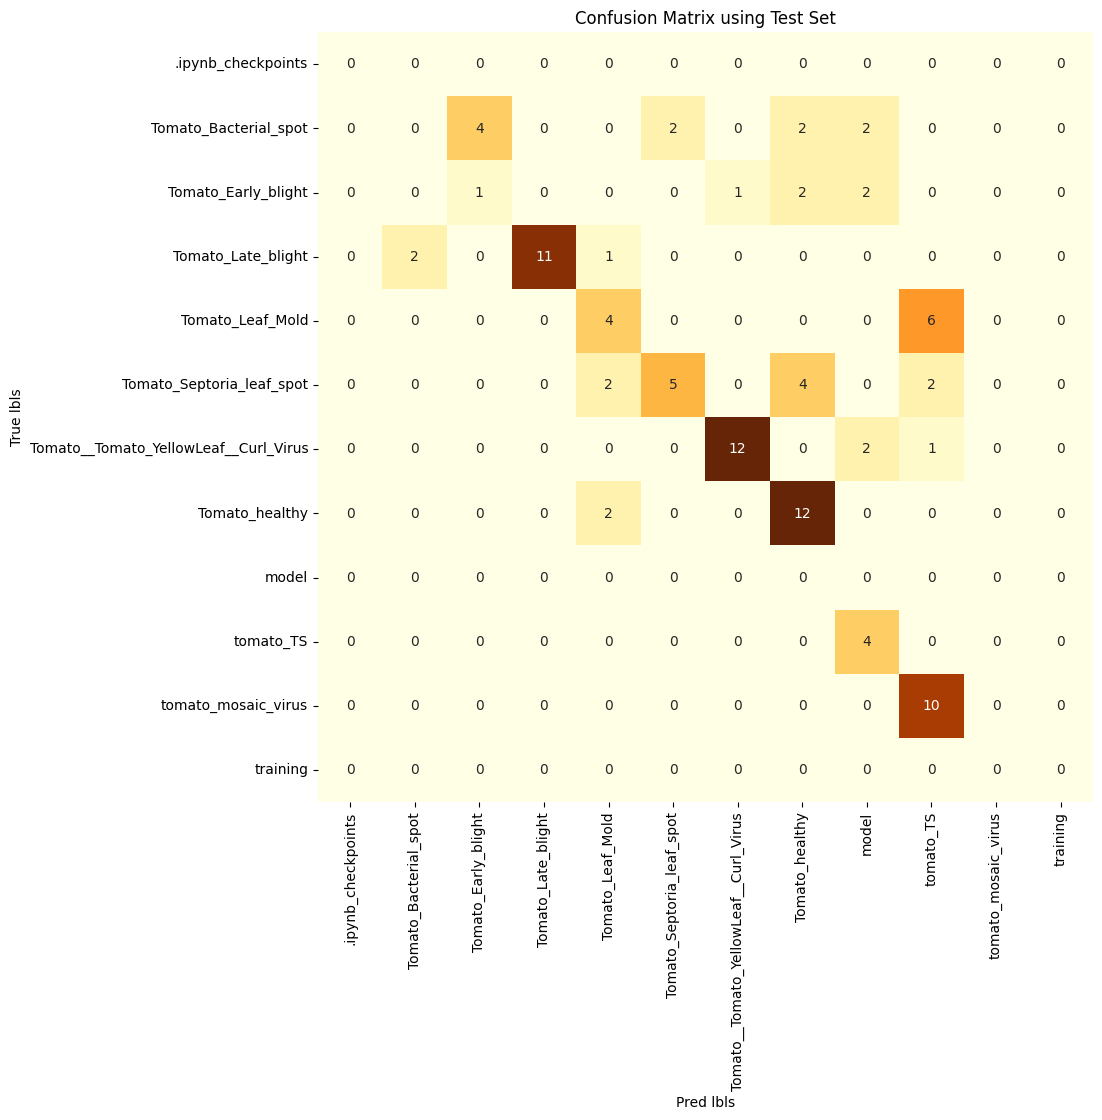

In [36]:
# plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt='g', 
            xticklabels=class_names, yticklabels=class_names, 
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()
     


In [37]:

# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)
     

<ipython-input-37-ae67f679288e>:3: RuntimeWarning: invalid value encountered in true_divide
  prec_matrix = cf_matrix / pred_sums
<ipython-input-37-ae67f679288e>:8: RuntimeWarning: divide by zero encountered in true_divide
  recall_matrix = cf_matrix / true_sums
<ipython-input-37-ae67f679288e>:8: RuntimeWarning: invalid value encountered in true_divide
  recall_matrix = cf_matrix / true_sums
<ipython-input-37-ae67f679288e>:12: RuntimeWarning: invalid value encountered in true_divide
  f1s = (2 * precs * recalls) / (precs + recalls)


In [38]:

# displaying testing set counts
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+---------------------------------------+----+
| .ipynb_checkpoints                    |  0 |
+---------------------------------------+----+
| Tomato_Bacterial_spot                 | 10 |
+---------------------------------------+----+
| Tomato_Early_blight                   |  6 |
+---------------------------------------+----+
| Tomato_Late_blight                    | 14 |
+---------------------------------------+----+
| Tomato_Leaf_Mold                      | 10 |
+---------------------------------------+----+
| Tomato_Septoria_leaf_spot             | 13 |
+---------------------------------------+----+
| Tomato__Tomato_YellowLeaf__Curl_Virus | 15 |
+---------------------------------------+----+
| Tomato_healthy                        | 14 |
+---------------------------------------+----+
| model                                 |  0 |
+---------------------------------------+----+
| tomato_TS                             |  4 |
+---------------------------------------+--

In [39]:
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s}, 
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
.ipynb_checkpoints,NaN,NaN,NaN
Tomato_Bacterial_spot,0.00%,0.00%,NaN
Tomato_Early_blight,20.00%,16.67%,18.18%
Tomato_Late_blight,100.00%,78.57%,88.00%
Tomato_Leaf_Mold,44.44%,40.00%,42.11%
Tomato_Septoria_leaf_spot,71.43%,38.46%,50.00%
Tomato__Tomato_YellowLeaf__Curl_Virus,92.31%,80.00%,85.71%
Tomato_healthy,60.00%,85.71%,70.59%
model,0.00%,NaN,NaN
tomato_TS,0.00%,0.00%,NaN


In [40]:
macro_f1 = round(evals_df['F1'].mean() * 100, 2)
micro_f1 = round(np.sum(cf_matrix.diagonal()) / np.sum(cf_matrix) * 100, 2)
print(f'Macro F1: {macro_f1}%')
print(f'Micro F1: {micro_f1}%')
     


Macro F1: 59.1%
Micro F1: 46.88%


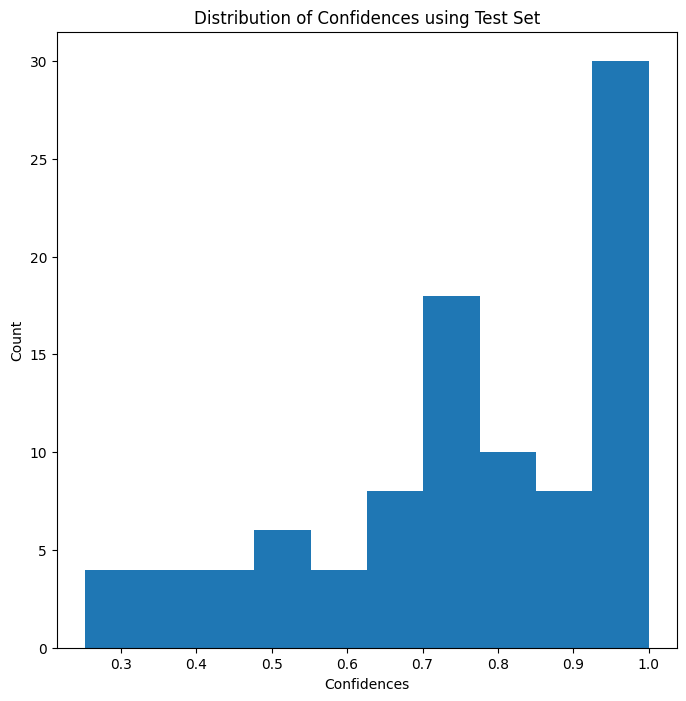

In [41]:

# plotting distribution of confidences
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()

True lbl : Tomato_healthy
Pred lbl : Tomato_healthy
Conf     : 99.8%


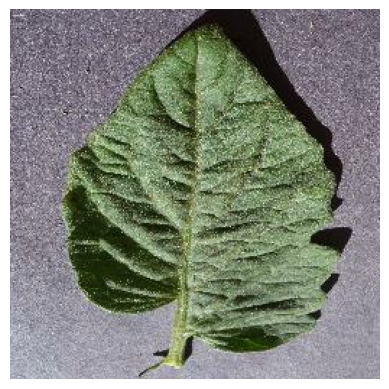

In [44]:
# displaying random image results
rand_batch = random.randint(1, test_size)
rand_img = random.randint(0, BATCH_SIZE - 1)

i = (rand_batch - 1) * BATCH_SIZE
lbl_true_name = lbls_true_names[i:i + BATCH_SIZE][rand_img]
lbl_pred_name = lbls_pred_names[i:i + BATCH_SIZE][rand_img]
pred_conf = pred_confs[i:i + BATCH_SIZE][rand_img]

print(f'True lbl : {lbl_true_name}')
print(f'Pred lbl : {lbl_pred_name}')
print(f'Conf     : {round(100 * pred_conf, 2)}%')

for imgs, lbls in test_set.take(rand_batch):
    plt.imshow(imgs[rand_img].numpy().astype('uint8'))
    plt.axis('off')
    break

In [43]:
# saving latest model
model_ver = len(os.listdir(models_dir)) # latest saved model
model_ver += 1
model.save(f'{models_dir}/{model_ver}')